In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision as tv
from torchvision.transforms import v2
from diffusers import utils
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm
from copy import deepcopy

In [3]:
device = (
    'cuda' 
    if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(device)

mps


-train.csv: A training dataset comprising 60’000 photoplethysmography (PPG) signals sampled at 100 Hz (30-second duration each), as well as five additional features.
First 3000 labelled columns (ppg_0,…, ppg_2999) correspond to the time series of the raw input optical signal.
Last 5 labelled columns (feature_0,…,feature_4) correspond to engineered features containing relevant information.
<br>-train_labels.csv: continuous labels.
<br>-test.csv: A test dataset comprising 30’000 recordings with no labels, with the same format as the train.csv file.
The password to download the data is: cheese! Please let us know if you experience any issues.
 

The idea is to spend a maximum of 12 hours to:

·                     Use the training set to design a deep learning-based solution to predict the continuous labels of these PPG signals.

·                     Generate the outputs for the 30’000 recordings of the test dataset and share the obtained outputs as well as your code by email at the latest on the Monday 23rd of June (in the morning)

·                     Report and present your approach, results and findings in a maximum of five slides during the next interview. You will have 15-20 minutes for your presentation followed by a 10-15 minutes Q&A.

 

While the performance of your proposed approach is important to us, we are equally interested in your creativity and how you present your work and results. The interview will take place at our office in Neuchâtel and will also be an opportunity to meet other members of the Aktiia Team.

## TODO
* check ouptut for windows
* Define baseline
* make sure test and val are from the same distribution

# 0. Imports

In [4]:
train_df = pd.read_csv('../data/Aktiia/train.csv').head(5000)
print(train_df.shape)
# train.head()

(5000, 3005)


In [5]:
train_l = pd.read_csv('../data/Aktiia/train_labels.csv').head(5000)
print(train_l.shape)
# train_l.head()

(5000, 1)


In [6]:
train_df['label'] = train_l['target']
print(train_df.shape)
train_df

(5000, 3006)


,ppg_0,ppg_1,ppg_2,ppg_3,ppg_4,ppg_5,ppg_6,ppg_7,ppg_8,ppg_9,...,ppg_2996,ppg_2997,ppg_2998,ppg_2999,features_0,features_1,features_2,features_3,features_4,label
0,2495829.8,2496739.2,2494858.2,2492765.2,2491843.5,2494595.0,2492085.0,2490652.5,2490777.2,2496773.8,...,2419126.0,2418873.2,2416466.5,2428702.8,-1.251488,1.009981,0.603974,0.252646,1.949994,2.641616
1,2501260.0,2501346.0,2501102.5,2500992.2,2500849.5,2500811.5,2500517.5,2500474.2,2500427.2,2500511.2,...,2420832.8,2420860.2,2421016.8,2420952.0,0.087479,1.475090,0.033434,0.252646,0.715404,-0.535309
2,2501591.0,2502997.0,2511711.8,2501036.2,2496703.5,2503340.8,2498449.8,2493474.8,2505062.5,2497219.8,...,2421374.5,2423805.2,2422972.8,2423857.0,-0.715901,1.087499,0.603974,0.252646,1.209240,5.717096
3,2517803.5,2507316.5,2514108.2,2517570.8,2513305.8,2514936.0,2510431.0,2514905.8,2515988.8,2510290.5,...,2434174.0,2437226.2,2432477.2,2431346.5,1.069389,0.002245,-1.250281,0.252646,-0.272268,3.789291
4,2513730.2,2519822.8,2512720.8,2509725.5,2503305.5,2491827.2,2512113.8,2514973.2,2512475.0,2509586.2,...,2439123.5,2449905.8,2444987.5,2456793.8,-0.626637,0.932463,1.174513,0.252646,0.550792,4.469064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2512603.0,2512961.0,2513222.8,2513361.5,2513557.0,2513607.0,2513291.5,2513009.0,2512746.2,2512439.8,...,2461740.5,2461893.5,2462122.2,2462312.0,0.444537,1.397572,0.318704,0.252646,0.797710,-6.735516
4996,2494393.8,2490805.0,2492220.2,2495849.8,2504897.5,2512423.5,2511270.0,2515573.2,2513144.5,2498458.0,...,2411444.0,2422137.8,2421328.8,2417236.5,-0.715901,1.087499,0.603974,0.252646,-0.766104,2.538932
4997,2498572.0,2495521.5,2506222.5,2503759.2,2497432.2,2502862.2,2502136.5,2503674.2,2500271.0,2499111.5,...,2419121.2,2424820.8,2419368.5,2418570.0,1.426447,-1.780673,-1.107646,0.252646,1.044628,2.957908
4998,2512603.0,2512974.8,2513241.5,2513372.2,2513600.8,2513544.5,2513225.8,2512938.2,2512654.5,2512338.5,...,2452234.8,2451847.5,2451535.5,2451152.0,1.069389,0.002245,-1.250281,0.252646,-0.272268,-8.708679


In [7]:
# test_f = pd.read_csv('../data/Aktiia/test.csv').values.astype('float32')
# print(test_f.shape)
# test_f.head()

## 1. Data Pre-processing

In [8]:
ppg_t = train_df.drop(['features_0','features_1','features_2','features_3','features_4','label'],axis=1)
ppg_t['mean'] = ppg_t.mean(axis=1)
ppg_t['std']  = ppg_t.std(axis=1)
ppg_t

,ppg_0,ppg_1,ppg_2,ppg_3,ppg_4,ppg_5,ppg_6,ppg_7,ppg_8,ppg_9,...,ppg_2992,ppg_2993,ppg_2994,ppg_2995,ppg_2996,ppg_2997,ppg_2998,ppg_2999,mean,std
0,2495829.8,2496739.2,2494858.2,2492765.2,2491843.5,2494595.0,2492085.0,2490652.5,2490777.2,2496773.8,...,2425789.5,2421214.8,2421410.2,2419608.0,2419126.0,2418873.2,2416466.5,2428702.8,2.466881e+06,16232.461266
1,2501260.0,2501346.0,2501102.5,2500992.2,2500849.5,2500811.5,2500517.5,2500474.2,2500427.2,2500511.2,...,2420961.2,2420901.0,2420913.2,2420643.8,2420832.8,2420860.2,2421016.8,2420952.0,2.471324e+06,18618.810490
2,2501591.0,2502997.0,2511711.8,2501036.2,2496703.5,2503340.8,2498449.8,2493474.8,2505062.5,2497219.8,...,2415520.0,2423314.0,2417380.2,2419963.2,2421374.5,2423805.2,2422972.8,2423857.0,2.470274e+06,18367.036637
3,2517803.5,2507316.5,2514108.2,2517570.8,2513305.8,2514936.0,2510431.0,2514905.8,2515988.8,2510290.5,...,2436394.0,2440193.8,2437883.8,2437999.5,2434174.0,2437226.2,2432477.2,2431346.5,2.474104e+06,17773.194105
4,2513730.2,2519822.8,2512720.8,2509725.5,2503305.5,2491827.2,2512113.8,2514973.2,2512475.0,2509586.2,...,2443513.0,2440165.0,2441026.2,2437442.0,2439123.5,2449905.8,2444987.5,2456793.8,2.475243e+06,18211.322275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2512603.0,2512961.0,2513222.8,2513361.5,2513557.0,2513607.0,2513291.5,2513009.0,2512746.2,2512439.8,...,2461055.5,2461082.2,2461186.8,2461479.0,2461740.5,2461893.5,2462122.2,2462312.0,2.477332e+06,15242.129526
4996,2494393.8,2490805.0,2492220.2,2495849.8,2504897.5,2512423.5,2511270.0,2515573.2,2513144.5,2498458.0,...,2426661.2,2424532.0,2413389.8,2422082.5,2411444.0,2422137.8,2421328.8,2417236.5,2.470308e+06,20287.767112
4997,2498572.0,2495521.5,2506222.5,2503759.2,2497432.2,2502862.2,2502136.5,2503674.2,2500271.0,2499111.5,...,2427754.0,2422663.8,2416927.2,2419386.2,2419121.2,2424820.8,2419368.5,2418570.0,2.471430e+06,19006.246723
4998,2512603.0,2512974.8,2513241.5,2513372.2,2513600.8,2513544.5,2513225.8,2512938.2,2512654.5,2512338.5,...,2454059.8,2453525.5,2453088.0,2452681.5,2452234.8,2451847.5,2451535.5,2451152.0,2.476612e+06,15417.498553


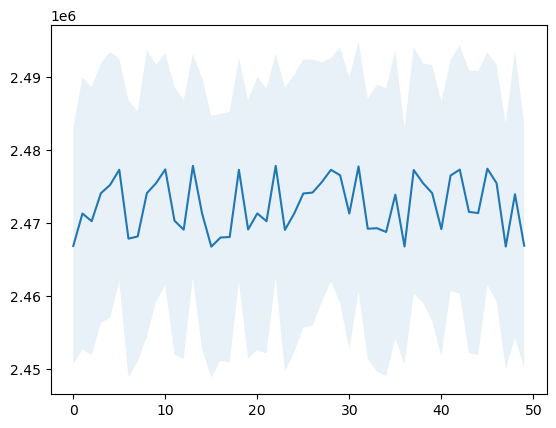

In [9]:
## display mean ppg at teach timestep and standard deviation
s = 50
plt.plot(ppg_t['mean'][:s])
plt.fill_between(range(s),ppg_t['mean'][:s]-ppg_t['std'][:s],ppg_t['mean'][:s]+ppg_t['std'][:s],alpha=.1)
plt.show()

In [10]:
# making train set based on means:
# X = train[['features_0','features_1','features_2','features_3','features_4']]
# X['ppg_mean'] = ppg_t[['mean']].copy()
X             = train_df.drop('label',axis=1)
y             = train_df[['label']]

# make train and validation sets:
# train-test split for time series
train_size = int(X.shape[0] * 0.90)
test_size = X.shape[0] - train_size
X_raw_train, X_raw_val = X[:train_size], X[train_size:]
y_raw_train, y_raw_val  = y[:train_size], y[train_size:]

## feature scaling:
# train_mean = X_raw_train.mean()
# train_std  = X_raw_train.std()

train_mean = X.mean()
train_std  = X.std()

X_raw_train = (X_raw_train - train_mean) / train_std
X_raw_val = (X_raw_val - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std
X_raw_train

,ppg_0,ppg_1,ppg_2,ppg_3,ppg_4,ppg_5,ppg_6,ppg_7,ppg_8,ppg_9,...,ppg_2995,ppg_2996,ppg_2997,ppg_2998,ppg_2999,features_0,features_1,features_2,features_3,features_4
0,-1.137086,-1.021871,-1.239519,-1.457626,-1.537480,-1.232143,-1.514127,-1.701459,-1.677851,-1.001303,...,-0.878848,-0.911918,-0.927515,-1.067947,-0.357267,-1.238679,1.005177,0.582361,0.249470,1.935399
1,-0.487850,-0.488195,-0.522813,-0.525033,-0.547033,-0.546012,-0.563877,-0.580228,-0.568104,-0.562530,...,-0.820381,-0.815196,-0.814551,-0.808973,-0.797357,0.093138,1.473113,0.015538,0.249470,0.706418
2,-0.448275,-0.296935,0.694898,-0.520045,-1.002995,-0.266847,-0.796884,-1.379269,-0.035046,-0.948942,...,-0.858798,-0.784498,-0.647123,-0.697650,-0.632411,-0.705952,1.083166,0.582361,0.249470,1.198011
3,1.490095,0.203458,0.969951,1.354277,0.822866,1.012945,0.553265,1.067264,1.221476,0.585566,...,0.159271,-0.059162,0.115882,-0.156719,-0.207158,1.069805,-0.008685,-1.259812,0.249470,-0.276767
4,1.003091,1.652252,0.810708,0.464953,-0.276931,-1.537632,0.742898,1.074958,0.817390,0.502881,...,0.127803,0.221321,0.836737,0.555289,1.237738,-0.617164,0.927188,1.149183,0.249470,0.542554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,0.678795,0.945064,0.382519,1.107611,0.866824,0.472870,0.879589,1.289668,0.650893,1.028789,...,1.412306,1.550863,1.531258,1.530051,1.569219,-0.528376,0.849198,1.007478,0.249470,0.952215
4496,-1.083917,-1.309862,-1.098480,-1.327197,-1.277749,-1.244483,-1.150457,-1.429956,-1.521935,-1.170830,...,-0.618396,-0.928069,-0.611386,-1.096632,-0.785603,-1.149891,1.239145,1.007478,0.249470,0.132894
4497,-0.889428,-1.547854,-1.306686,-1.569816,-0.965878,-1.201482,-1.538333,-1.114307,-1.503420,-1.336482,...,-0.982510,-0.553498,-0.752264,-1.035137,-0.563412,0.625865,-0.164664,1.149183,0.249470,0.706418
4498,-2.923112,-1.976110,-0.634755,-1.736758,-0.823568,-0.993242,-0.430116,0.950069,-0.893864,-1.959680,...,-1.271229,-1.321080,-0.501281,-1.202395,-0.698730,0.004351,-1.178526,-1.118107,0.249470,-0.440631


In [11]:
## create sliding windows:
def create_dataset(X_,y_, lookback,v=False):
    """Transform a time series into a prediction dataset
    params df X_: the raw feature dataset
    params df y_: the labels
    params int lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(X_.shape[0]-lookback):
        if v:
            print('X:',i,'-',i+lookback,'; y:',i+lookback)
        feature = X_.iloc[i:i+lookback]
        target  = y_.iloc[i:i+lookback]
        X.append(feature.to_numpy(dtype='float32'))
        y.append(target.to_numpy(dtype='float32'))
    return torch.tensor(X), torch.tensor(y)

In [12]:
# X_raw_train.head(26)

In [161]:
%%time
lookback = 1
X_train, y_train = create_dataset(X_raw_train, y_raw_train, lookback=lookback,v=False)
X_val, y_val     = create_dataset(X_raw_val, y_raw_val, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([4499, 1, 3005]) torch.Size([4499, 1, 1])
torch.Size([499, 1, 3005]) torch.Size([499, 1, 1])
CPU times: user 832 ms, sys: 12.3 ms, total: 844 ms
Wall time: 844 ms


In [162]:
# X_train[1]

In [163]:
# y_train[1]

In [472]:
## Building a very simple LSTM model
class lstm(nn.Module):
    def __init__(self,hidden_size,lstm_input_size):
        """
        A simple lstm model to predict time series
        """
        super().__init__()
        self.lstm      = nn.LSTM(input_size=lstm_input_size, hidden_size=hidden_size, num_layers=1, batch_first=True) # ,dropout=0.25
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.linear    = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

class mlp(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.fc1   = nn.Linear(input_size,128)
        self.fc2   = nn.Linear(128,64)
        self.fc3   = nn.Linear(64,1)

    def forward(self,x):
        # convolutional layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # output
        x = self.fc3(x)
        return x

class cnn_lstm_simple(nn.Module):
    def __init__(self,hidden_size,lstm_input_size):
        """
        A simple cnn_lstm model to predict time series
        """
        super().__init__()
        # convolution
        self.conv = nn.Conv1d(in_channels=1, out_channels=1, 
                              kernel_size=4, padding=2, 
                              padding_mode='replicate')
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        # lstm
        self.lstm      = nn.LSTM(input_size=lstm_input_size, hidden_size=hidden_size, num_layers=1, batch_first=True) # ,dropout=0.25
        self.linear    = nn.Linear(hidden_size, 1)
        
    def forward(self, x):

        # x = x.permute(0,3,1)
        x = self.conv(x)
        x = self.maxpool(x)
        # maxpool_out = maxpool_out.permute(0,2,1)
        # return x
        
        x, _ = self.lstm(x)
        # extract only the last time step?
        # x = x[:, -1, :]
        # print(x)
        # x = self.batchnorm(x)
        x = self.linear(x)
        return x

class cnn_lstm(nn.Module):
    def __init__(self,hidden_size,input_size):
        """
        A simple cnn_lstm model to predict time series
        """
        super().__init__()
        
        # convolution
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16,kernel_size=4, padding=2, padding_mode='zeros')
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32,kernel_size=4, padding=2, padding_mode='zeros')
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1) # kernel size =3 for conv2
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(16 * input_size, 512)
        self.fc2 = nn.Linear(512, 128 )
        # lstm
        self.lstm      = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=1, batch_first=True) # ,dropout=0.25
        self.linear    = nn.Linear(hidden_size, 1)
        
    def forward(self, x):

        # Convolution
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool(x) # tmp
        
        # x = self.conv2(x)
        # x = F.relu(x)
        # x = self.maxpool(x)
        x = self.dropout1(x)
        x = torch.flatten(x,-2)
        
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.stack([x],dim = 0) # convert 1d tensor to 2d for lstm input

        x    = torch.permute(x, (1, 0, 2)) # arrange dimensions so that matches lstm input for batch processing
        x, _ = self.lstm(x)
        # extract only the last time step?
        # x = x[:, -1, :]
        # print(x)
        # x = self.batchnorm(x)
        x = self.linear(x)
        return x

In [482]:
16 * 3005

48080

In [473]:
if 1<3:
    ## simple training of the model
    h_s             = 32
    input_size      = X_train.shape[-1]
    batch_size      = 8
    model           = cnn_lstm(h_s,input_size) # cnn_lstm_simple(32,input_size) # lstm(h_s, input_size) # mlp(input_size) # 
    optimizer       = optim.Adam(model.parameters(),lr=1e-5,)
    loss_fn         = nn.MSELoss()
    loader          = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
     
    n_epochs = 1
    for epoch in tqdm(range(n_epochs)):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)#.reshape(y_batch.shape[0],1)
            break
print('> lstm final shape: [8, 1, 1]')
y_pred.shape

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 139.08it/s]

> lstm final shape: [8, 1, 1]


torch.Size([8, 1, 1])

In [479]:
# y_pred

In [475]:
if 11<3:
    ## make one forward pass to make sure everything works:
    h_s             = 8
    input_size      = X_train.shape[-1]
    model           = lstm(h_s,input_size) # cnn_lstm(32,input_size) # mlp(input_size) # lstm(h_s,input_size)
    loss_fn         = nn.MSELoss()
    
    X_0    = X_train[0]
    y_0    = y_train[0]
    y_pred = model(X_0)

    loss   = loss_fn(y_pred, y_0)
    print(loss,y_pred)
    print('>> input size',input_size)
    print(y_pred.shape)

tensor(5.8202, grad_fn=<MseLossBackward0>) tensor([[0.2291]], grad_fn=<AddmmBackward0>)
>> input size 3005
torch.Size([1, 1])


In [476]:
y_pred

tensor([[0.2291]], grad_fn=<AddmmBackward0>)

In [477]:
y_0

tensor([[2.6416]])

In [368]:
if 11<3:
    X_1    = X_train[1]
    y_1    = y_train[1]
    y_pred = model(X_1)
    loss   = loss_fn(y_pred, y_1)
    print(loss,y_1,y_pred)

In [369]:
## check Baseline model:
y_val_np = y_val.detach().numpy().flatten()
y_val_nofirst = torch.tensor(np.delete(y_val_np, 0))
y_val_nolast  = torch.tensor(np.delete(y_val_np, -1))

loss_fn       = nn.MSELoss()
base_rmse     = np.sqrt(loss_fn(y_val_nofirst, y_val_nolast))
print('>> Baseline rmse:',base_rmse.numpy())

>> Baseline rmse: 6.8800015


In [371]:
## simple training of the model
h_s             = 32
input_size      = X_train.shape[-1]
batch_size      = 8
model           = cnn_lstm(h_s,input_size) # lstm(h_s, input_size) # mlp(input_size) # 
optimizer       = optim.Adam(model.parameters(),lr=1e-5,)
loss_fn         = nn.MSELoss()
loader          = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
 
n_epochs = 10
for epoch in tqdm(range(n_epochs)):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)#.reshape(y_batch.shape[0],1)
        break
y_pred.shape

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 703.33it/s]


torch.Size([8, 1, 1])

In [294]:
y_pred[0].shape

torch.Size([16, 3006])

In [478]:
## simple training of the model
h_s             = 32
input_size      = X_train.shape[-1]
batch_size      = 8
model           = cnn_lstm(h_s,input_size) # lstm(h_s, input_size) # mlp(input_size) # 
optimizer       = optim.Adam(model.parameters(),lr=1e-5,)
loss_fn         = nn.MSELoss()
loader          = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
 
n_epochs = 20
for epoch in tqdm(range(n_epochs)):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)#.reshape(y_batch.shape[0],1)
        loss = loss_fn(y_pred, y_batch)
        # print(y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        # Checking rsme on whole training set
        y_pred_t   = model(X_train)#.reshape(y_train.shape[0],1)
        train_rmse = np.sqrt(loss_fn(y_pred_t, y_train))
        # Checking rsme on validation set
        y_pred_v = model(X_val)#.reshape(y_val.shape[0],1)
        val_rmse = np.sqrt(loss_fn(y_pred_v, y_val))
    print("Epoch %d: train RMSE %.4f, validation RMSE %.4f" % (epoch, train_rmse, val_rmse))
    # break

  5%|██▏                                         | 1/20 [00:25<07:56, 25.10s/it]

Epoch 0: train RMSE 4.3069, validation RMSE 4.0750


 55%|███████████████████████▋                   | 11/20 [04:12<03:27, 23.04s/it]

Epoch 10: train RMSE 3.5654, validation RMSE 3.4528


100%|███████████████████████████████████████████| 20/20 [07:34<00:00, 22.70s/it]


>> RMSE train: 3.0754514


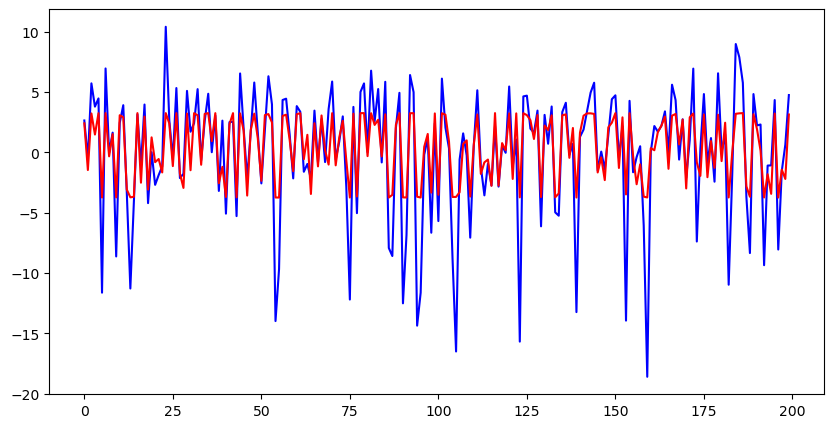

In [480]:
## plot training set results:
with torch.no_grad():
    y_real = y_train[:, -1, :]
    y_hat  = model(X_train)[:, -1, :] # you take the last prediction (last of 2nd element of 3D tensor)
    print('>> RMSE train:',np.sqrt(loss_fn(y_hat, y_real)).detach().numpy() )
# plot
plt.figure(figsize=(10,5))
plt.plot(y_real[:200], c='b')
plt.plot(y_hat[:200], c='r')
plt.show()

>> RMSE validation: 3.107108


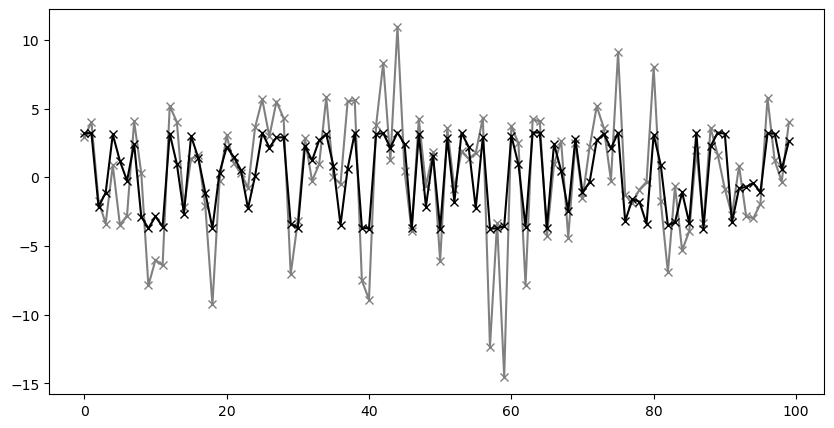

In [481]:
## plot validation set results:
with torch.no_grad():
    y_real = y_val[:, -1, :]
    y_hat  = model(X_val)[:, -1, :] # you take the last prediction (last of 2nd element of 3D tensor)
    print('>> RMSE validation:',np.sqrt(loss_fn(y_hat, y_real)).detach().numpy() )
# plot
plt.figure(figsize=(10,5))
plt.plot(y_real[:100], c='grey',marker='x')
plt.plot(y_hat[:100], c='black',marker='x')
plt.show()

In [57]:
print('done')

done
